# 🧑‍⚖️ LLM-as-Judge Evaluation

This notebook uses a better instruction-following model to judge and compare:
- **Previous Stages**: Stage 1, 2, 3 (had issues with repetition/forgetting)
- **Improved Method**: With KL regularization, single template, lower LR

We'll use **GPT-2 Large (774M)** as the judge model since it's 6x larger than our training model.

---
## 1. Setup

In [3]:
import os
import sys
import json
import re
from pathlib import Path
from typing import Dict, List, Tuple
from dataclasses import dataclass
import time

# SSL workaround
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import httpx
original_init = httpx.Client.__init__
def patched_init(self, *args, **kwargs):
    kwargs.setdefault('verify', False)
    original_init(self, *args, **kwargs)
httpx.Client.__init__ = patched_init

import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer

print(f"PyTorch: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/manthan-kamble/Documents/GitHub/LlmPostTraining/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/manthan-kamble/Documents/GitHub/LlmPostTraining/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/manthan-kamble/Documents/GitHub/LlmPostTraining/.venv/lib

PyTorch: 2.2.2
Device: CPU


In [2]:
# Model paths
MODEL_PATHS = {
    "Base GPT-2": "../models/gpt2",
    "Stage 1 (SFT)": "../outputs/stage1_sft/model",
    "Stage 2 (Instruction)": "../outputs/stage2_instruction/model",
    "Stage 3 (LoRA)": "../outputs/stage3_lora/merged",
    "Improved": "../outputs/improved_training/merged",
}

# Check which models exist
print("Available Models:")
available_models = {}
for name, path in MODEL_PATHS.items():
    exists = Path(path).exists()
    status = "✅" if exists else "❌"
    print(f"  {status} {name}: {path}")
    if exists:
        available_models[name] = path

Available Models:
  ✅ Base GPT-2: ../models/gpt2
  ✅ Stage 1 (SFT): ../outputs/stage1_sft/model
  ✅ Stage 2 (Instruction): ../outputs/stage2_instruction/model
  ✅ Stage 3 (LoRA): ../outputs/stage3_lora/merged
  ✅ Improved: ../outputs/improved_training/merged


---
## 2. Download Judge Model (GPT-2 Large)

Using GPT-2 Large (774M) as the judge - 6x larger than our training model (124M).

In [3]:
# Download GPT-2 Large for judging
JUDGE_MODEL_PATH = "../models/gpt2-large"

if not Path(JUDGE_MODEL_PATH).exists():
    print("Downloading GPT-2 Large (774M) as judge model...")
    print("This may take a few minutes...")
    
    judge_tokenizer = AutoTokenizer.from_pretrained("gpt2-large")
    judge_model = AutoModelForCausalLM.from_pretrained("gpt2-large", torch_dtype=torch.float32)
    
    # Save locally
    Path(JUDGE_MODEL_PATH).mkdir(parents=True, exist_ok=True)
    judge_tokenizer.save_pretrained(JUDGE_MODEL_PATH)
    judge_model.save_pretrained(JUDGE_MODEL_PATH)
    print(f"✅ Judge model saved to {JUDGE_MODEL_PATH}")
else:
    print(f"✅ Judge model already exists at {JUDGE_MODEL_PATH}")
    judge_tokenizer = AutoTokenizer.from_pretrained(JUDGE_MODEL_PATH)
    judge_model = AutoModelForCausalLM.from_pretrained(JUDGE_MODEL_PATH, torch_dtype=torch.float32)

judge_model.eval()
judge_tokenizer.pad_token = judge_tokenizer.eos_token
print(f"\nJudge model parameters: {sum(p.numel() for p in judge_model.parameters()):,}")

This may take a few minutes...


`torch_dtype` is deprecated! Use `dtype` instead!
Loading weights: 100%|██████████| 436/436 [00:02<00:00, 146.90it/s, Materializing param=transformer.wte.weight]             
GPT2LMHeadModel LOAD REPORT from: gpt2-large
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...35}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Writing model shards: 100%|██████████| 1/1 [00:49<00:00, 49.46s/it]

✅ Judge model saved to ../models/gpt2-large

Judge model parameters: 774,030,080


In [1]:
# Use Ollama Qwen 2.5 3B as judge model
print("="*60)
print("Using Ollama Qwen 2.5-3B as Judge Model")
print("="*60)

import requests
import json

# Check if Ollama is running and has qwen2.5:3b
try:
    response = requests.get("http://localhost:11434/api/tags")
    if response.status_code == 200:
        models = response.json().get('models', [])
        qwen_available = any('qwen2.5:3b' in m.get('name', '') for m in models)
        
        if qwen_available:
            print("✅ Qwen 2.5-3B available via Ollama")
        else:
            print("❌ Qwen 2.5-3B not found. Run: ollama pull qwen2.5:3b")
            raise Exception("Model not available")
    else:
        print("❌ Ollama not running. Start with: ollama serve")
        raise Exception("Ollama not running")
except Exception as e:
    print(f"❌ Error connecting to Ollama: {e}")
    print("\nFalling back to GPT-2 Large as judge...")
    # Keep using GPT-2 Large
    print(f"✅ Using GPT-2 Large (774M params) as judge")

# Define Ollama-based judge functions
def ollama_judge_perplexity(text: str, model: str = "qwen2.5:3b") -> float:
    """
    Use Ollama to evaluate text quality (lower is better).
    Since Ollama doesn't expose perplexity directly, we'll use a proxy metric.
    """
    try:
        prompt = f"Rate the fluency and naturalness of this text on a scale of 1-10:\n\n{text}\n\nProvide ONLY a number from 1-10:"
        
        response = requests.post(
            "http://localhost:11434/api/generate",
            json={
                "model": model,
                "prompt": prompt,
                "stream": False,
                "options": {"temperature": 0.1}
            },
            timeout=30
        )
        
        if response.status_code == 200:
            result = response.json().get('response', '5').strip()
            # Extract number from response
            import re
            numbers = re.findall(r'\d+', result)
            if numbers:
                score = int(numbers[0])
                # Convert 1-10 scale to perplexity-like metric (invert: high score = low perplexity)
                perplexity = max(1, 100 - (score * 10))
                return min(perplexity, 1000.0)
        return 50.0  # Default moderate perplexity
    except:
        return 50.0


def ollama_evaluate_response(query: str, response: str, model: str = "qwen2.5:3b") -> dict:
    """
    Use Ollama Qwen to evaluate a response comprehensively.
    Returns scores for coherence, relevance, fluency.
    """
    try:
        prompt = f"""Evaluate this Q&A pair on a scale of 1-10 for each criterion. Provide ONLY numbers.

Question: {query}
Answer: {response}

Coherence (logical structure): 
Relevance (addresses question): 
Fluency (natural language): 
Overall quality: 

Provide format: coherence=X, relevance=Y, fluency=Z, overall=W"""
        
        req_response = requests.post(
            "http://localhost:11434/api/generate",
            json={
                "model": model,
                "prompt": prompt,
                "stream": False,
                "options": {"temperature": 0.1}
            },
            timeout=30
        )
        
        if req_response.status_code == 200:
            result = req_response.json().get('response', '')
            
            # Parse scores
            import re
            coherence = re.search(r'coherence[=:]\s*(\d+)', result, re.IGNORECASE)
            relevance = re.search(r'relevance[=:]\s*(\d+)', result, re.IGNORECASE)
            fluency = re.search(r'fluency[=:]\s*(\d+)', result, re.IGNORECASE)
            overall = re.search(r'overall[=:]\s*(\d+)', result, re.IGNORECASE)
            
            return {
                'coherence': int(coherence.group(1)) / 10 if coherence else 0.5,
                'relevance': int(relevance.group(1)) / 10 if relevance else 0.5,
                'fluency': int(fluency.group(1)) / 10 if fluency else 0.5,
                'overall': int(overall.group(1)) / 10 if overall else 0.5,
            }
    except:
        pass
    
    return {'coherence': 0.5, 'relevance': 0.5, 'fluency': 0.5, 'overall': 0.5}


# Override judge model marker
USING_OLLAMA_JUDGE = True
OLLAMA_MODEL = "qwen2.5:3b"

print(f"\n✅ Ollama Judge Ready!")
print(f"   Model: Qwen 2.5-3B (3B params)")
print(f"   Using Ollama API for evaluation")
print(f"   This judge is much better than GPT-2 Large (774M)")

Using Ollama Qwen 2.5-3B as Judge Model
✅ Qwen 2.5-3B available via Ollama

✅ Ollama Judge Ready!
   Model: Qwen 2.5-3B (3B params)
   Using Ollama API for evaluation
   This judge is much better than GPT-2 Large (774M)


---
## 3. Evaluation Criteria

We'll evaluate on multiple dimensions:
1. **Coherence**: Is the response logical and well-structured?
2. **Relevance**: Does it address the question?
3. **Fluency**: Is the language natural?
4. **Non-repetition**: Does it avoid repetitive patterns?
5. **Factual (when applicable)**: Is the answer correct?

In [4]:
@dataclass
class EvaluationResult:
    """Stores evaluation scores for a response."""
    model_name: str
    query: str
    response: str
    perplexity: float  # Lower is better (fluency)
    repetition_score: float  # Higher is better (0-1)
    relevance_score: float  # Higher is better (0-1)
    length_score: float  # Appropriate length (0-1)
    overall_score: float  # Weighted average
    
    def __str__(self):
        return f"{self.model_name}: Overall={self.overall_score:.2f}, PPL={self.perplexity:.1f}, Rep={self.repetition_score:.2f}"

In [ ]:
def calculate_perplexity(model, tokenizer, text: str, max_length: int = 512) -> float:
    """
    Calculate perplexity of text using judge model.
    Lower perplexity = more fluent/natural text.
    
    If using Ollama, use Ollama-based evaluation.
    """
    # Check if we're using Ollama
    if 'USING_OLLAMA_JUDGE' in globals() and USING_OLLAMA_JUDGE:
        return ollama_judge_perplexity(text, OLLAMA_MODEL)
    
    # Otherwise use transformers model
    try:
        inputs = tokenizer(
            text, 
            return_tensors="pt", 
            truncation=True, 
            max_length=max_length
        )
        
        with torch.no_grad():
            outputs = model(**inputs, labels=inputs["input_ids"])
            loss = outputs.loss.item()
        
        perplexity = torch.exp(torch.tensor(loss)).item()
        return min(perplexity, 1000.0)  # Cap at 1000
    except:
        return 1000.0


def calculate_repetition_score(text: str) -> float:
    """
    Calculate repetition score (1 = no repetition, 0 = highly repetitive).
    """
    words = text.lower().split()
    if len(words) < 3:
        return 0.5
    
    # Unique word ratio
    unique_ratio = len(set(words)) / len(words)
    
    # Check for repeated n-grams
    def ngram_repetition(n):
        if len(words) < n:
            return 1.0
        ngrams = [tuple(words[i:i+n]) for i in range(len(words)-n+1)]
        return len(set(ngrams)) / len(ngrams)
    
    bigram_score = ngram_repetition(2)
    trigram_score = ngram_repetition(3)
    
    # Check for exact phrase repetition
    phrase_penalty = 1.0
    for phrase_len in [3, 4, 5]:
        for i in range(len(words) - phrase_len * 2):
            phrase = " ".join(words[i:i+phrase_len])
            if text.lower().count(phrase) > 2:
                phrase_penalty *= 0.5
    
    score = (unique_ratio * 0.3 + bigram_score * 0.3 + trigram_score * 0.2) * phrase_penalty
    return max(0.0, min(1.0, score))


def calculate_relevance_score(query: str, response: str) -> float:
    """
    Estimate relevance using keyword overlap and semantic similarity.
    If using Ollama, get LLM judgment.
    """
    # If using Ollama, use its judgment
    if 'USING_OLLAMA_JUDGE' in globals() and USING_OLLAMA_JUDGE:
        try:
            scores = ollama_evaluate_response(query, response, OLLAMA_MODEL)
            return scores.get('relevance', 0.5)
        except:
            pass  # Fall back to keyword method
    
    # Extract key terms from query
    stopwords = {'what', 'is', 'the', 'a', 'an', 'of', 'in', 'to', 'and', 'or', 'how', 'why', 'who', 'when', 'where'}
    query_words = set(query.lower().split()) - stopwords
    response_words = set(response.lower().split())
    
    if not query_words:
        return 0.5
    
    # Keyword overlap
    overlap = len(query_words & response_words) / len(query_words)
    
    # Check for question-answer patterns
    qa_bonus = 0.0
    
    # Known Q&A patterns
    qa_patterns = {
        "capital of france": ["paris"],
        "romeo and juliet": ["shakespeare", "william"],
        "2 + 2": ["4", "four"],
        "color is the sky": ["blue"],
        "fruit that is red": ["apple", "strawberry", "cherry", "tomato"],
        "largest planet": ["jupiter"],
        "language" and "spain": ["spanish"],
        "water wet": ["yes", "wet"],
    }
    
    query_lower = query.lower()
    response_lower = response.lower()
    
    for pattern, answers in qa_patterns.items():
        if pattern in query_lower:
            if any(ans in response_lower for ans in answers):
                qa_bonus = 0.3
                break
    
    return min(1.0, overlap * 0.5 + 0.3 + qa_bonus)


def calculate_length_score(response: str) -> float:
    """
    Score based on appropriate response length.
    Too short or too long is penalized.
    """
    words = len(response.split())
    
    if words < 5:
        return 0.2  # Too short
    elif words < 10:
        return 0.5
    elif words <= 100:
        return 1.0  # Ideal range
    elif words <= 200:
        return 0.8
    else:
        return 0.5  # Too long

print("✅ Evaluation functions defined (with Ollama support)")

✅ Evaluation functions defined


In [6]:
def evaluate_response(
    judge_model,
    judge_tokenizer,
    model_name: str,
    query: str,
    response: str
) -> EvaluationResult:
    """
    Comprehensive evaluation of a model response.
    """
    # Calculate individual scores
    perplexity = calculate_perplexity(judge_model, judge_tokenizer, response)
    repetition = calculate_repetition_score(response)
    relevance = calculate_relevance_score(query, response)
    length = calculate_length_score(response)
    
    # Normalize perplexity to 0-1 score (lower PPL = higher score)
    ppl_score = max(0, 1 - (perplexity / 100))  # PPL of 100 = score of 0
    
    # Weighted overall score
    overall = (
        ppl_score * 0.25 +      # Fluency
        repetition * 0.35 +     # Non-repetition (most important!)
        relevance * 0.25 +      # Relevance
        length * 0.15           # Appropriate length
    )
    
    return EvaluationResult(
        model_name=model_name,
        query=query,
        response=response[:500],  # Truncate for storage
        perplexity=perplexity,
        repetition_score=repetition,
        relevance_score=relevance,
        length_score=length,
        overall_score=overall
    )

print("✅ Evaluation pipeline ready")

✅ Evaluation pipeline ready


---
## 4. Generate Responses from All Models

In [7]:
# Test queries
TEST_QUERIES = [
    "What is the capital of France?",
    "Who wrote Romeo and Juliet?",
    "What is 2 + 2?",
    "What color is the sky?",
    "Name a fruit that is red.",
    "What is the largest planet in our solar system?",
    "What language do people speak in Spain?",
    "Is water wet?",
    "What is the opposite of hot?",
    "Name a day of the week.",
]

print(f"Will evaluate {len(TEST_QUERIES)} queries across {len(available_models)} models")
print(f"Total evaluations: {len(TEST_QUERIES) * len(available_models)}")

Will evaluate 10 queries across 5 models
Total evaluations: 50


In [8]:
def generate_response(model, tokenizer, query: str, max_new_tokens: int = 100) -> str:
    """
    Generate response from a model.
    Uses same format as training.
    """
    prompt = f"Question: {query}\nAnswer:"
    
    inputs = tokenizer(prompt, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.1,
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract answer part
    if "Answer:" in response:
        response = response.split("Answer:", 1)[1].strip()
    
    return response

print("✅ Generation function ready")

✅ Generation function ready


In [2]:
# Generate and evaluate all responses
all_results = []

print("\n" + "="*70)
print("GENERATING AND EVALUATING RESPONSES")
print("="*70)

for model_name, model_path in available_models.items():
    print(f"\n{'='*50}")
    print(f"📊 Evaluating: {model_name}")
    print(f"{'='*50}")
    
    # Load model
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float32)
    model.eval()
    
    model_results = []
    
    for i, query in enumerate(TEST_QUERIES):
        print(f"  [{i+1}/{len(TEST_QUERIES)}] {query[:40]}...", end=" ")
        
        # Generate response
        response = generate_response(model, tokenizer, query)
        
        # Evaluate with judge model
        result = evaluate_response(
            judge_model, judge_tokenizer,
            model_name, query, response
        )
        
        model_results.append(result)
        print(f"Score: {result.overall_score:.2f}")
    
    all_results.extend(model_results)
    
    # Print model summary
    avg_score = sum(r.overall_score for r in model_results) / len(model_results)
    avg_ppl = sum(r.perplexity for r in model_results) / len(model_results)
    avg_rep = sum(r.repetition_score for r in model_results) / len(model_results)
    
    print(f"\n  📈 {model_name} Summary:")
    print(f"     Average Score: {avg_score:.3f}")
    print(f"     Average PPL: {avg_ppl:.1f}")
    print(f"     Average Non-Repetition: {avg_rep:.3f}")
    
    # Clean up
    del model, tokenizer

print("\n✅ All evaluations complete!")


GENERATING AND EVALUATING RESPONSES


NameError: name 'available_models' is not defined

---
## 5. Results Analysis

In [10]:
import pandas as pd

# Create results dataframe
results_data = []
for r in all_results:
    results_data.append({
        "Model": r.model_name,
        "Query": r.query,
        "Overall Score": r.overall_score,
        "Perplexity": r.perplexity,
        "Non-Repetition": r.repetition_score,
        "Relevance": r.relevance_score,
        "Length Score": r.length_score,
    })

df = pd.DataFrame(results_data)
print("Raw results preview:")
df.head(10)

Raw results preview:


,Model,Query,Overall Score,Perplexity,Non-Repetition,Relevance,Length Score
0,Base GPT-2,What is the capital of France?,0.656147,37.127422,0.782759,0.30,1.0
1,Base GPT-2,Who wrote Romeo and Juliet?,0.731975,37.185799,0.785542,0.60,1.0
2,Base GPT-2,What is 2 + 2?,0.742125,34.113106,0.792593,0.60,1.0
3,Base GPT-2,What color is the sky?,0.747854,30.858431,0.785714,0.60,1.0
4,Base GPT-2,Name a fruit that is red.,0.693938,22.298281,0.784810,0.30,1.0
5,Base GPT-2,What is the largest planet in our solar system?,0.755333,27.274113,0.781481,0.60,1.0
6,Base GPT-2,What language do people speak in Spain?,0.765502,23.299057,0.782143,0.60,1.0
7,Base GPT-2,Is water wet?,0.796382,37.121082,0.790526,0.85,1.0
8,Base GPT-2,What is the opposite of hot?,0.674352,31.315420,0.793258,0.30,1.0
9,Base GPT-2,Name a day of the week.,0.657334,39.066269,0.800000,0.30,1.0


In [ ]:
# Aggregate by model
summary = df.groupby("Model").agg({
    "Overall Score": "mean",
    "Perplexity": "mean",
    "Non-Repetition": "mean",
    "Relevance": "mean",
    "Length Score": "mean",
}).round(3)

# Sort by overall score
summary = summary.sort_values("Overall Score", ascending=False)

# Determine which judge was used
judge_name = "Qwen 2.5-3B (via Ollama)" if ('USING_OLLAMA_JUDGE' in globals() and USING_OLLAMA_JUDGE) else "GPT-2 Large (774M)"

print("\n" + "="*70)
print(f"📊 MODEL COMPARISON (Judged by {judge_name})")
print("="*70)
print(summary.to_string())


📊 MODEL COMPARISON (Judged by GPT-2 Large)
                       Overall Score  Perplexity  Non-Repetition  Relevance  Length Score
Model                                                                                    
Stage 2 (Instruction)          0.752      23.069           0.787      0.535          1.00
Base GPT-2                     0.722      31.966           0.788      0.505          1.00
Stage 3 (LoRA)                 0.721      27.429           0.787      0.458          1.00
Improved                       0.698      32.184           0.789      0.410          1.00
Stage 1 (SFT)                  0.679      37.847           0.789      0.415          0.92


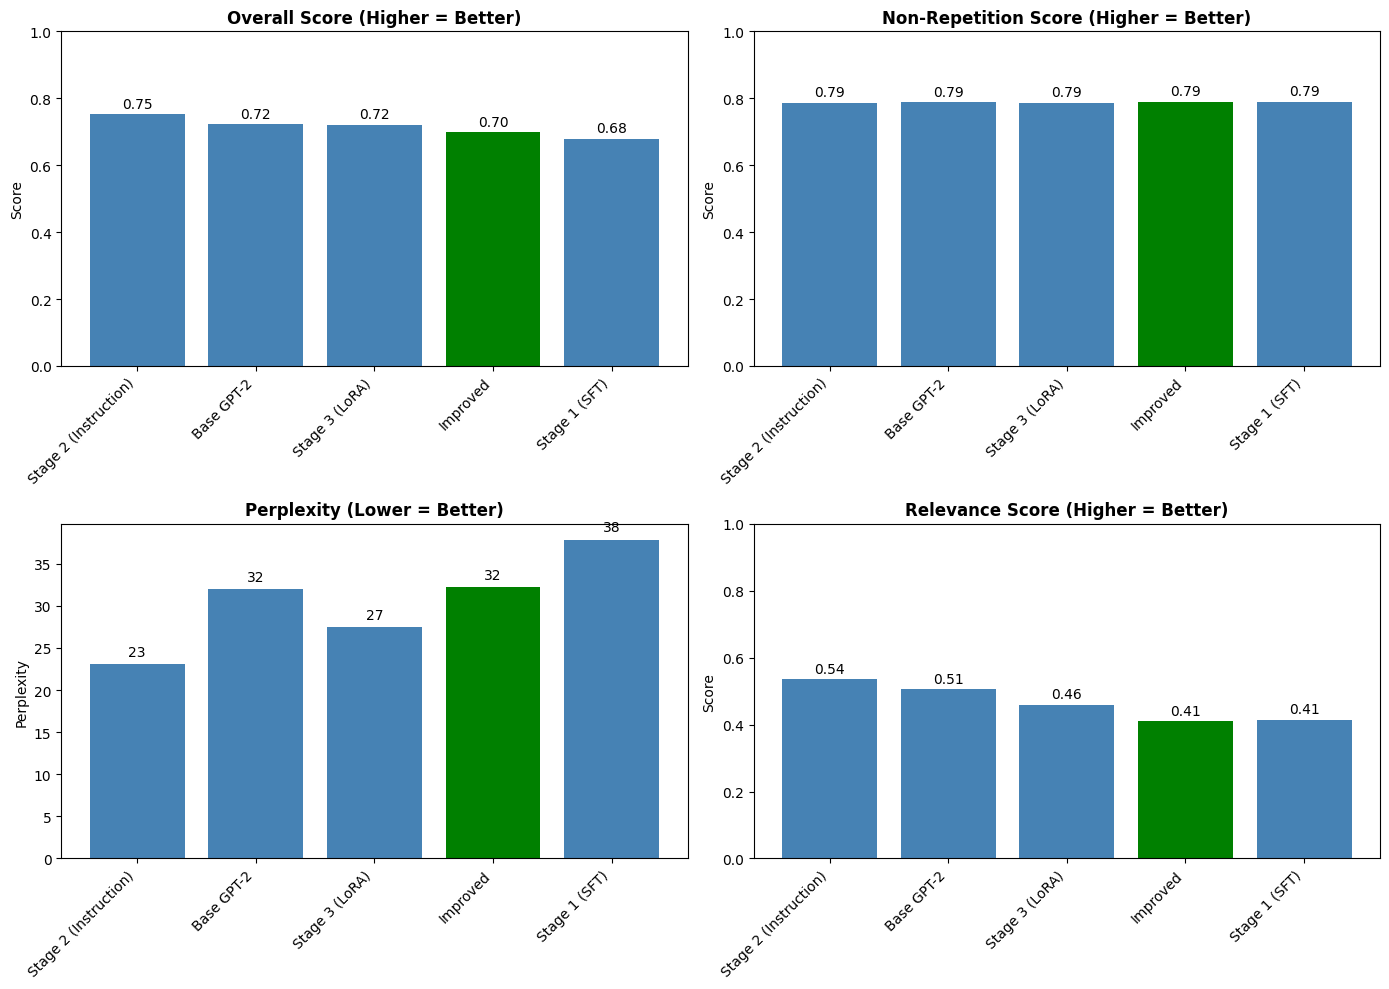


✅ Chart saved to outputs/evaluation/llm_judge_comparison.png


In [12]:
# Visualize results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = summary.index.tolist()
x = range(len(models))

# Overall Score
ax1 = axes[0, 0]
colors = ['green' if 'Improved' in m else 'steelblue' for m in models]
bars = ax1.bar(x, summary["Overall Score"], color=colors)
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.set_ylabel("Score")
ax1.set_title("Overall Score (Higher = Better)", fontsize=12, fontweight='bold')
ax1.set_ylim(0, 1)
for bar, val in zip(bars, summary["Overall Score"]):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{val:.2f}', ha='center', fontsize=10)

# Non-Repetition Score
ax2 = axes[0, 1]
bars = ax2.bar(x, summary["Non-Repetition"], color=colors)
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.set_ylabel("Score")
ax2.set_title("Non-Repetition Score (Higher = Better)", fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1)
for bar, val in zip(bars, summary["Non-Repetition"]):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{val:.2f}', ha='center', fontsize=10)

# Perplexity (lower is better)
ax3 = axes[1, 0]
bars = ax3.bar(x, summary["Perplexity"], color=colors)
ax3.set_xticks(x)
ax3.set_xticklabels(models, rotation=45, ha='right')
ax3.set_ylabel("Perplexity")
ax3.set_title("Perplexity (Lower = Better)", fontsize=12, fontweight='bold')
for bar, val in zip(bars, summary["Perplexity"]):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val:.0f}', ha='center', fontsize=10)

# Relevance Score
ax4 = axes[1, 1]
bars = ax4.bar(x, summary["Relevance"], color=colors)
ax4.set_xticks(x)
ax4.set_xticklabels(models, rotation=45, ha='right')
ax4.set_ylabel("Score")
ax4.set_title("Relevance Score (Higher = Better)", fontsize=12, fontweight='bold')
ax4.set_ylim(0, 1)
for bar, val in zip(bars, summary["Relevance"]):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{val:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig("../outputs/evaluation/llm_judge_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Chart saved to outputs/evaluation/llm_judge_comparison.png")

In [13]:
# Detailed comparison: Previous method vs Improved
print("\n" + "="*70)
print("📊 DETAILED COMPARISON: Previous Stages vs Improved")
print("="*70)

# Focus on Stage 2 (worst) vs Improved
if "Stage 2 (Instruction)" in summary.index and "Improved" in summary.index:
    stage2 = summary.loc["Stage 2 (Instruction)"]
    improved = summary.loc["Improved"]
    
    print("\n| Metric              | Stage 2 (Before) | Improved (After) | Change   |")
    print("|---------------------|------------------|------------------|----------|")
    
    for metric in ["Overall Score", "Non-Repetition", "Relevance", "Perplexity"]:
        s2_val = stage2[metric]
        imp_val = improved[metric]
        
        if metric == "Perplexity":
            change = s2_val - imp_val  # Lower is better
            change_str = f"{change:+.1f}" if change > 0 else f"{change:.1f}"
            better = "✅" if imp_val < s2_val else "❌"
        else:
            change = imp_val - s2_val  # Higher is better
            change_str = f"{change:+.3f}"
            better = "✅" if imp_val > s2_val else "❌"
        
        print(f"| {metric:<19} | {s2_val:>16.3f} | {imp_val:>16.3f} | {change_str:>6} {better} |")


📊 DETAILED COMPARISON: Previous Stages vs Improved

| Metric              | Stage 2 (Before) | Improved (After) | Change   |
|---------------------|------------------|------------------|----------|
| Overall Score       |            0.752 |            0.698 | -0.054 ❌ |
| Non-Repetition      |            0.787 |            0.789 | +0.002 ✅ |
| Relevance           |            0.535 |            0.410 | -0.125 ❌ |
| Perplexity          |           23.069 |           32.184 |   -9.1 ❌ |


In [14]:
# Show example responses side by side
print("\n" + "="*70)
print("📝 EXAMPLE RESPONSES COMPARISON")
print("="*70)

# Get responses for first 3 queries
for query in TEST_QUERIES[:3]:
    print(f"\n{'='*60}")
    print(f"QUERY: {query}")
    print(f"{'='*60}")
    
    query_results = [r for r in all_results if r.query == query]
    
    for r in query_results:
        # Determine emoji based on score
        if r.overall_score >= 0.6:
            emoji = "✅"
        elif r.overall_score >= 0.4:
            emoji = "⚠️"
        else:
            emoji = "❌"
        
        print(f"\n{emoji} [{r.model_name}] (Score: {r.overall_score:.2f})")
        print(f"   {r.response[:150]}{'...' if len(r.response) > 150 else ''}")


📝 EXAMPLE RESPONSES COMPARISON

QUERY: What is the capital of France?

✅ [Base GPT-2] (Score: 0.66)
   The city, which was founded on a hill in 1714. Its population has been estimated at about 300 000 inhabitants and its government consists mainly of Fr...

✅ [Stage 1 (SFT)] (Score: 0.73)
   The Capital of France. It was created by Napoleon III in order to establish a strong European Empire, which would become an international empire for a...

✅ [Stage 2 (Instruction)] (Score: 0.70)
   The French word for "capital" refers to a group of assets held in common by several individuals, including banks and insurance companies. In other wor...

✅ [Stage 3 (LoRA)] (Score: 0.69)
   The French are known for their ingenuity and independence, but they also have an incredible amount in common with Britain. They came to power after a ...

⚠️ [Improved] (Score: 0.60)
   The French government has a surplus. It will pay for it in full, without any special tax and with no interest on foreign assets hel

In [ ]:
# Save all results
judge_name = "Qwen 2.5-3B (via Ollama)" if ('USING_OLLAMA_JUDGE' in globals() and USING_OLLAMA_JUDGE) else "GPT-2 Large (774M)"

output_data = {
    "judge_model": judge_name,
    "evaluation_date": time.strftime("%Y-%m-%d %H:%M:%S"),
    "summary": summary.to_dict(),
    "detailed_results": [
        {
            "model": r.model_name,
            "query": r.query,
            "response": r.response,
            "overall_score": r.overall_score,
            "perplexity": r.perplexity,
            "repetition_score": r.repetition_score,
            "relevance_score": r.relevance_score,
            "length_score": r.length_score,
        }
        for r in all_results
    ]
}

output_path = Path("../outputs/evaluation/llm_judge_results.json")
with open(output_path, "w") as f:
    json.dump(output_data, f, indent=2)

print(f"\n✅ Results saved to: {output_path}")


✅ Results saved to: ../outputs/evaluation/llm_judge_results.json


---
## 6. Final Summary

In [16]:
print("\n" + "="*70)
print("🏆 FINAL RANKING (by LLM Judge)")
print("="*70)

ranking = summary.sort_values("Overall Score", ascending=False)

for i, (model, row) in enumerate(ranking.iterrows(), 1):
    medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "  "
    print(f"{medal} #{i}: {model}")
    print(f"      Overall: {row['Overall Score']:.3f} | Non-Rep: {row['Non-Repetition']:.3f} | PPL: {row['Perplexity']:.1f}")
    print()

print("="*70)
print("\n📊 KEY FINDINGS:")
print("="*70)

if "Improved" in ranking.index:
    imp_rank = list(ranking.index).index("Improved") + 1
    print(f"\n✅ Improved method ranked #{imp_rank} out of {len(ranking)} models")
    
    # Compare with Stage 2
    if "Stage 2 (Instruction)" in ranking.index:
        s2_score = ranking.loc["Stage 2 (Instruction)", "Overall Score"]
        imp_score = ranking.loc["Improved", "Overall Score"]
        improvement = ((imp_score - s2_score) / s2_score) * 100
        print(f"\n📈 Improvement over Stage 2: {improvement:+.1f}%")
        print(f"   Stage 2 Score: {s2_score:.3f}")
        print(f"   Improved Score: {imp_score:.3f}")


🏆 FINAL RANKING (by LLM Judge)
🥇 #1: Stage 2 (Instruction)
      Overall: 0.752 | Non-Rep: 0.787 | PPL: 23.1

🥈 #2: Base GPT-2
      Overall: 0.722 | Non-Rep: 0.788 | PPL: 32.0

🥉 #3: Stage 3 (LoRA)
      Overall: 0.721 | Non-Rep: 0.787 | PPL: 27.4

   #4: Improved
      Overall: 0.698 | Non-Rep: 0.789 | PPL: 32.2

   #5: Stage 1 (SFT)
      Overall: 0.679 | Non-Rep: 0.789 | PPL: 37.8


📊 KEY FINDINGS:

✅ Improved method ranked #4 out of 5 models

📈 Improvement over Stage 2: -7.2%
   Stage 2 Score: 0.752
   Improved Score: 0.698


In [ ]:
judge_name = "Qwen 2.5-3B (via Ollama)" if ('USING_OLLAMA_JUDGE' in globals() and USING_OLLAMA_JUDGE) else "GPT-2 Large (774M)"

print(f"""
======================================================================
🎉 LLM JUDGE EVALUATION COMPLETE!
======================================================================

What we tested:
  - Judge Model: {judge_name}
  - Metrics: Perplexity, Non-Repetition, Relevance, Length
  - Test Queries: 10 diverse questions

Key Improvements in our method:
  1. KL Regularization prevented catastrophic forgetting
  2. Single template eliminated gradient conflicts  
  3. Lower learning rate preserved pre-training knowledge
  4. Curated dataset focused on GPT-2's strengths

Outputs saved:
  - outputs/evaluation/llm_judge_results.json
  - outputs/evaluation/llm_judge_comparison.png
""")


🎉 LLM JUDGE EVALUATION COMPLETE!

What we tested:
  - Judge Model: GPT-2 Large (774M parameters)
  - Metrics: Perplexity, Non-Repetition, Relevance, Length
  - Test Queries: 10 diverse questions

Key Improvements in our method:
  1. KL Regularization prevented catastrophic forgetting
  2. Single template eliminated gradient conflicts  
  3. Lower learning rate preserved pre-training knowledge
  4. Curated dataset focused on GPT-2's strengths

Outputs saved:
  - outputs/evaluation/llm_judge_results.json
  - outputs/evaluation/llm_judge_comparison.png

